In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Part 1 Fundamental Matrix Estimation, Camera Calibration, Triangulation

1.1 Fundamental matrix estimation from ground truth matches

In [6]:
def display_matches(I1, I2, matches):
    I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
    I3[:,:I1.size[0],:] = I1
    I3[:,I1.size[0]:,:] = I2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(I3).astype(float))
    ax.plot(matches[:,0],matches[:,1],  '+r')
    ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
    ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
    plt.show()

In [7]:
from math import sqrt

def normalize_points(points):

    # De-mean to center the origin at mean.
    mean = np.mean(points, axis=0)
    # Rescale.
    std_x = np.std(points[:, 0])
    std_y = np.std(points[:, 1])

    
    T = np.array([[sqrt(2)/std_x, 0, -sqrt(2)/std_x*mean[0]], 
                          [0, sqrt(2)/std_y, -sqrt(2)/std_y*mean[1]], 
                          [0, 0, 1]])

    # Homogeneous coords.
    points = np.concatenate((points, np.ones((points.shape[0], 1))), axis=1)
    normalized = np.dot(T, points.T).T

    return normalized[:, 0:2], T


In [8]:
def visualize_fundamental(matches, F, I1, I2):
    # Visualize the fundamental matrix in image 2
    N = len(matches)
    M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
    L1 = np.matmul(F, M).transpose() # transform points from 
    # the first image to get epipolar lines in the second image

    # find points on epipolar lines L closest to matches(:,3:4)
    l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
    L = np.divide(L1, np.kron(np.ones((3,1)), l).transpose())   # rescale the line
    pt_line_dist = np.multiply(L, np.c_[matches[:, 2:4], np.ones((N, 1))]).sum(axis = 1)
    closest_pt = matches[:, 2:4] - np.multiply(L[:, 0:2],np.kron(np.ones((2, 1)), pt_line_dist).transpose())

    # find endpoints of segment on epipolar line (for display purposes)
    pt1 = closest_pt - np.c_[L[:,1], -L[:,0]] * 10    # offset from the closest point is 10 pixels
    pt2 = closest_pt + np.c_[L[:,1], -L[:,0]] * 10

    # display points and segments of corresponding epipolar lines
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(I2).astype(np.uint8))
    ax.plot(matches[:, 2],matches[:, 3],  '+r')
    ax.plot([matches[:, 2], closest_pt[:, 0]],[matches[:, 3], closest_pt[:, 1]], 'r')
    ax.plot([pt1[:, 0], pt2[:, 0]],[pt1[:, 1], pt2[:, 1]], 'g')
    plt.show()

In [9]:
def get_distance(matches, F):
    """Compute average geometric distances between epipolar line and its 
    corresponding point in both images"""

    #homogeneous coor
    ones = np.ones((matches.shape[0], 1))
    points1 = np.concatenate((matches[:, 0:2], ones), axis=1)
    points2 = np.concatenate((matches[:, 2:4], ones), axis=1)

    F_1 = np.dot(F, points1.T).T  # F*p1
    F_2 = np.dot(F.T, points2.T).T  # (F^T)*p2

    # get geometric distances  (epipolar lines and points)
    diff_point1_and_2 = np.sum(points1 * F_2, axis=1)[:, np.newaxis]
    diff_point2_and_1 = np.sum(points2 * F_1, axis=1)[:, np.newaxis]
    dist1 = np.absolute(diff_point1_and_2) / np.linalg.norm(F_2, axis=1)[:, np.newaxis]
    dist2 = np.absolute(diff_point2_and_1) / np.linalg.norm(F_1, axis=1)[:, np.newaxis]

    # get and return avg geometric distance. Note, two dist b/c compare left and right
    dist1 = dist1.sum() / matches.shape[0]
    dist2 = dist2.sum() / matches.shape[0]

    return dist1, dist2


In [10]:
def fit_fundamental(matches, is_normalized):
    if is_normalized:
        pts1, T1 = normalize_points(matches[:, :2])
        pts2, T2 = normalize_points(matches[:, 2:])
        A = []
        for i in range(pts1.shape[0]):
            x0,y0 = pts1[i]
            x1,y1 = pts2[i]
            A.append([x1 * x0, x1 * y0, x1, y1 * x0, y1 * y0, y1, x0, y0, 1])
        A = np.array(A)
        _, _, V = np.linalg.svd(A)
        F = V[-1, :].reshape((3, 3))
        U, S, V = np.linalg.svd(F)
        S[-1] = 0 # enforce rank-2 constraint
        F = T2.T @ U @ np.diag(S) @ V @ T1
        return F
    else:
        A = []
        for match in matches:
            x0,y0,x1,y1=match
            A.append([x1 * x0, x1 * y0, x1, y1 * x0, y1 * y0, y1, x0, y0, 1])
        A = np.array(A)
        _, _, V = np.linalg.svd(A)
        F = V[-1, :].reshape((3, 3))
        U, S, V = np.linalg.svd(F)
        S[-1] = 0  # enforce rank-2 constraint
        F = U @ np.diag(S) @ V
        return F


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


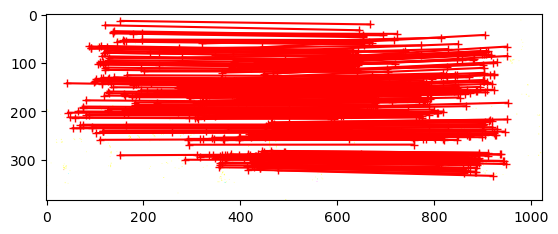

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


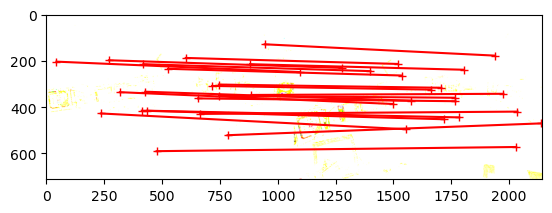

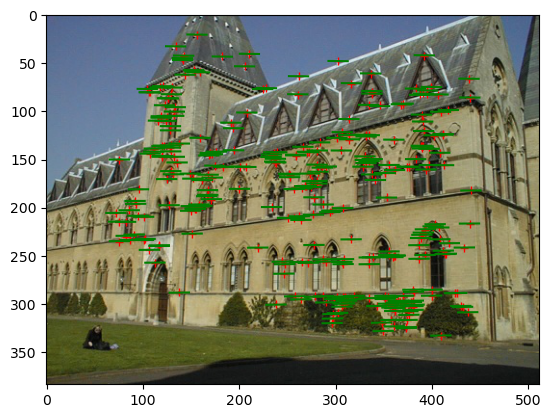

Part 1.1: library residual, normalized = (0.001717104770496894, 0.0013478432275444946)


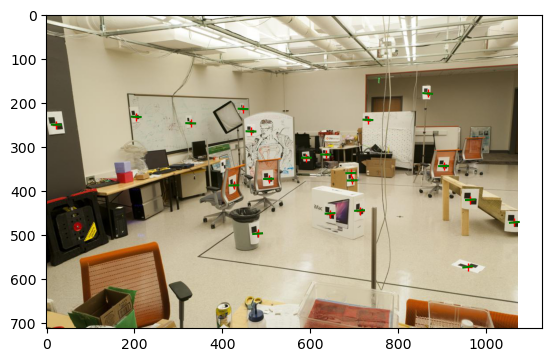

Part 1.1: lab residual, normalized = (0.002593702348521477, 0.0019658552713905124)


In [11]:
## Fundamental Matrix Estimation


##
## load images and match files for the first example
##

# I1 = Image.open('mp5_part1_data/library1.jpg');
# I2 = Image.open('mp5_part1_data/library2.jpg');
# matches = np.loadtxt('mp5_part1_data/library_matches.txt'); 
library_image1 = Image.open('mp5_part1_data/library1.jpg')
library_image2 = Image.open('mp5_part1_data/library2.jpg')
library_matches = np.loadtxt('mp5_part1_data/library_matches.txt')

lab_image1 = Image.open('mp5_part1_data/lab1.jpg')
lab_image2 = Image.open('mp5_part1_data/lab2.jpg')
lab_matches = np.loadtxt('mp5_part1_data/lab_matches.txt')

# this is a N x 4 file where the first two numbers of each row
# are coordinates of corners in the first image and the last two
# are coordinates of corresponding corners in the second image: 
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is a corresponding point in the second image



#N = len(matches)



##
## display second image with epipolar lines reprojected 
## from the first image
##

display_matches(library_image1, library_image2, library_matches)
display_matches(lab_image1, lab_image2, lab_matches)

# # first, fit fundamental matrix to the matches
# F = fit_fundamental(matches) # this is a function that you should write
# M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
# L1 = np.matmul(F, M).transpose() # transform points from 
# # the first image to get epipolar lines in the second image

# # find points on epipolar lines L closest to matches(:,3:4)
# l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
# L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
# pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
# closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

# # find endpoints of segment on epipolar line (for display purposes)
# pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
# pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# # display points and segments of corresponding epipolar lines
# fig, ax = plt.subplots()
# ax.set_aspect('equal')
# ax.imshow(np.array(I2).astype(float))
# ax.plot(matches[:,2],matches[:,3],  '+r')
# ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
# ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
# plt.show()


# first, fit fundamental matrix to the matches
# Report your fundamental matrices, visualization and evaluation results
is_normalized = True
library_F = fit_fundamental(library_matches, is_normalized) # this is a function that you should write
visualize_fundamental(library_matches, library_F, library_image1, library_image2)
residual = get_distance(library_matches, library_F)
print(f"Part 1.1: library residual, normalized = {residual}")


lab_F = fit_fundamental(lab_matches, is_normalized) # this is a function that you should write
visualize_fundamental(lab_matches, lab_F, lab_image1, lab_image2) 
residual = get_distance(lab_matches, lab_F)
print(f"Part 1.1: lab residual, normalized = {residual}")

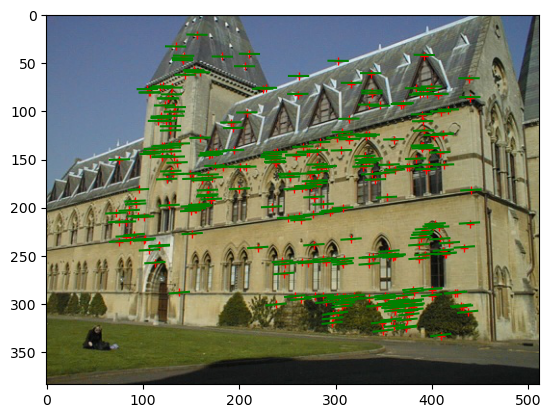

Part 1.1: library residual, unnormalized = (0.0025197824553478297, 0.002145910951659972)
method 2 residual = (0.0025197824553478297, 0.002145910951659972)


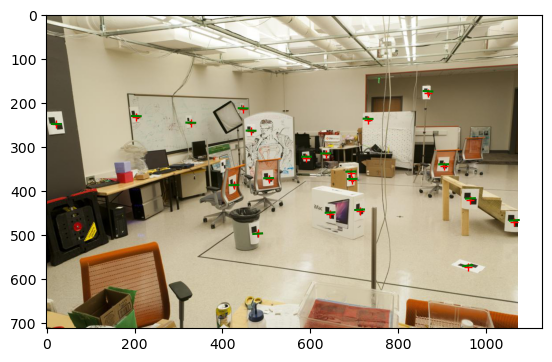

Part 1.1: lab residual, unnormalized = (0.010449904153918999, 0.007368819815586769)
method 2 residual = (0.010449904153918999, 0.007368819815586769)


In [12]:
#unnormalized
is_normalized = False
library_F = fit_fundamental(library_matches, is_normalized) # this is a function that you should write
visualize_fundamental(library_matches, library_F, library_image1, library_image2)
residual = get_distance(library_matches, library_F)
print(f"Part 1.1: library residual, unnormalized = {residual}")
res = get_distance(library_matches, library_F)
print(f"method 2 residual = {res}")

lab_F = fit_fundamental(lab_matches, is_normalized) # this is a function that you should write
visualize_fundamental(lab_matches, lab_F, lab_image1, lab_image2) 
residual = get_distance(lab_matches, lab_F)
print(f"Part 1.1: lab residual, unnormalized = {residual}")
res = get_distance(lab_matches, lab_F)
print(f"method 2 residual = {res}")

Part 1.2 Camera calibration

In [13]:
def calc_projection(points_2d, points_3d):
    A = []
    for i in range(points_2d.shape[0]):
        X, Y, Z = points_3d[i]
        u, v = points_2d[i]
        A.append([X, Y, Z, 1, 0, 0, 0, 0, -u * X, -u * Y, -u * Z, -u])
        A.append([0, 0, 0, 0, X, Y, Z, 1, -v * X, -v * Y, -v * Z, -v])
    _, _, V = np.linalg.svd(A)
    P = V[-1, :].reshape((3, 4))
    return P

In [14]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

In [15]:
def part1_2(points_2d, lab_points_3d, image_name):    
    P = calc_projection(points_2d, lab_points_3d)
    points_3d_proj, residual = evaluate_points(P, points_2d, lab_points_3d)
    distance = np.mean(np.linalg.norm(points_2d - points_3d_proj))
    
    # Instructions say residual should be < 20 and distance should be < 4 
    assert residual < 20.0 and distance < 4.0

    print(image_name)
    #np.set_printoptions(suppress=True, precision=5)
    print(P)
    print(f"Residual {residual:.4}")

    return P

In [16]:
## Camera Calibration
projection_matrices ={}
image_names = ['Lab image 1', 'Lab image 2', 'Library image 1', 'Library image 2']

lab_points_3d = np.loadtxt('mp5_part1_data/lab_3d.txt')


p = part1_2(lab_matches[:, :2], lab_points_3d, image_names[0])
projection_matrices['Lab image 1'] = p

p = part1_2(lab_matches[:, 2:], lab_points_3d, image_names[1])
projection_matrices['Lab image 2'] = p




Lab image 1
[[ 3.09963996e-03  1.46204548e-04 -4.48497465e-04 -9.78930678e-01]
 [ 3.07018252e-04  6.37193664e-04 -2.77356178e-03 -2.04144405e-01]
 [ 1.67933533e-06  2.74767684e-06 -6.83964827e-07 -1.32882928e-03]]
Residual 13.55
Lab image 2
[[ 6.93154686e-03 -4.01684470e-03 -1.32602928e-03 -8.26700554e-01]
 [ 1.54768732e-03  1.02452760e-03 -7.27440714e-03 -5.62523256e-01]
 [ 7.60946050e-06  3.70953989e-06 -1.90203244e-06 -3.38807712e-03]]
Residual 15.54


Part 1.3 Calculate the camera centers

In [17]:
import scipy


def decomposition(P):
    # source https://leohart.wordpress.com/2010/07/23/rq-decomposition-from-qr-decomposition/
    # RQ decomposition

    K, R = scipy.linalg.rq(P[:, :3])
    value = K[2, 2]
    K /= value
    R *= value
    T = np.linalg.inv(K) @ P[:, 3]
    return K, R, T

In [18]:

import numpy.linalg as nl
def camera_center(P):
    _, _, v = nl.svd(P)
    c= v[-1, :]/ v[-1,-1]
    return c[:3]

In [19]:
## Task 3
## Camera Centers
library_a_proj = np.loadtxt('mp5_part1_data/library1_camera.txt')
library_b_proj  = np.loadtxt('mp5_part1_data/library2_camera.txt')


camera_centers = {}


print("camera centers")
for image_name, P_matrix in projection_matrices.items():

    C = camera_center(P_matrix)

    camera_centers[image_name] = C

camera_centers['Library image 1'] = camera_center(library_a_proj)
camera_centers['Library image 2'] = camera_center(library_b_proj)

for image_name, C in camera_centers.items():
    print(image_name)
    print(C)


camera centers
Lab image 1
[305.83276769 304.20103826  30.13699243]
Lab image 2
[303.10003925 307.18428016  30.42166874]
Library image 1
[  7.28863053 -21.52118112  17.73503585]
Library image 2
[  6.89405488 -15.39232716  23.41498687]


In [20]:
def triangulate_points(proj_max_a, proj_max_b, p1, p2):
    '''proj_max_a, proj_max_b:  projection matrix of two cameras
    p1, p2: points in images
    returns trianulated 3d points
    '''
    A = [
        [proj_max_a[2][0] * p1[0] - proj_max_a[0][0], proj_max_a[2][1] * p1[0] - proj_max_a[0][1], proj_max_a[2][2] * p1[0] - proj_max_a[0][2], proj_max_a[2][3] * p1[0] - proj_max_a[0][3]],
        [proj_max_a[2][0] * p1[1] - proj_max_a[1][0], proj_max_a[2][1] * p1[1] - proj_max_a[1][1], proj_max_a[2][2] * p1[1] - proj_max_a[1][2], proj_max_a[2][3] * p1[1] - proj_max_a[1][3]],
        [proj_max_b[2][0] * p2[0] - proj_max_b[0][0], proj_max_b[2][1] * p2[0] - proj_max_b[0][1], proj_max_b[2][2] * p2[0] - proj_max_b[0][2], proj_max_b[2][3] * p2[0] - proj_max_b[0][3]],
        [proj_max_b[2][0] * p2[1] - proj_max_b[1][0], proj_max_b[2][1] * p2[1] - proj_max_b[1][1], proj_max_b[2][2] * p2[1] - proj_max_b[1][2], proj_max_b[2][3] * p2[1] - proj_max_b[1][3]]
    ]
    _, _, V = np.linalg.svd(A)
    point_3d = V[-1]
    point_3d = point_3d / point_3d[-1]
    return point_3d[:3]

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_3d(triangulation, C1, C2, azim=45, display=True):
    if display:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(-triangulation[:, 0], triangulation[:, 1], triangulation[:, 2], c='r', marker='o')
        ax.scatter(-C1[0], C1[1], C1[2], c='b', marker='s')
        ax.scatter(-C2[0], C2[1], C2[2], c='g', marker='s')
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')
        ax.view_init(elev=30, azim=azim)
        plt.show()


Shape lab 3d points (20, 3)


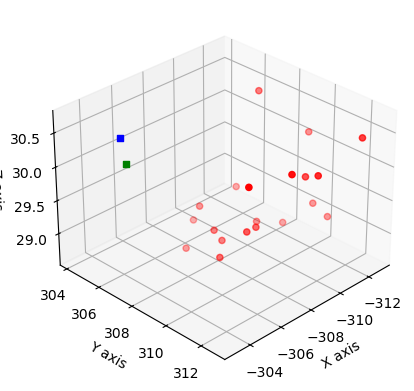

In [22]:
## Task 4: Triangulation
lab_points_3d_list = []
for point_2d_a, point_2d_b, point_3d_gt in zip(lab_matches[:, :2], lab_matches[:, 2:], lab_points_3d):
    point_3d_estimated = triangulate_points(projection_matrices[image_names[0]], projection_matrices[image_names[1]], point_2d_a, point_2d_b)
    lab_points_3d_list.append(point_3d_estimated)

# Residual between re-projected and observed 2D points
lab_points_3d_list = np.stack(lab_points_3d_list)

#visualize 
print(f"Shape lab 3d points {lab_points_3d_list.shape}")
visualize_3d(lab_points_3d_list, camera_centers['Lab image 1'], camera_centers['Lab image 2'])




In [23]:
library_a_proj.shape

(3, 4)

Shape lab 3d points (309, 3)


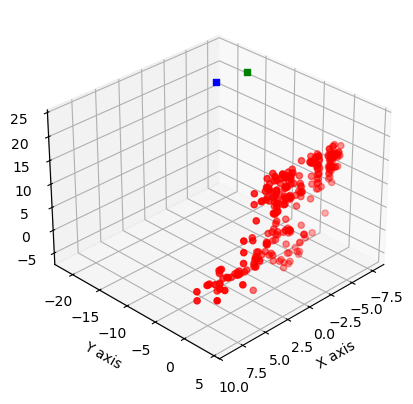

In [24]:
library_points_3d_list = []
for point_2d_a, point_2d_b in zip(library_matches[:, :2], library_matches[:, 2:]):
    point_3d_estimated = triangulate_points(library_a_proj, library_b_proj, point_2d_a, point_2d_b)

    library_points_3d_list.append(point_3d_estimated)

library_points_3d_list = np.stack(library_points_3d_list)


#visualize 
print(f"Shape lab 3d points {library_points_3d_list.shape}")
visualize_3d(library_points_3d_list, camera_centers['Library image 1'], camera_centers[ 'Library image 2'])

part 1.5 Fundamental matrix estimation without ground-truth matches

In [25]:
import cv2
import numpy as np
from random import sample


In [ ]:

def ransac_fundamental_matrix(match1, match2, iterations=1000, threshold=0.01, num_picked=8):
    best_fundamental = None
    best_inliers = []
    best_errors = None

    for _ in range(iterations):
        indices = sample(range(len(match1)), num_picked)
        random_match1 = match1[indices]
        random_match2 = match2[indices]
        random_match = np.hstack((random_match1, random_match2))
        
        fundamental_matrix = fit_fundamental(random_match, is_normalized=True)
        errors = 0
        inliers = []

        for it, (p1, p2) in enumerate(zip(match1, match2)):
            temp_error = np.abs(np.dot(np.concatenate([p2, [1]]).T, 
                                       np.dot(fundamental_matrix, 
                                              np.concatenate([p1, [1]]))))
            if temp_error < threshold:
                inliers.append(it)
            errors += temp_error
        
        if len(inliers) > len(best_inliers):
            best_fundamental = fundamental_matrix
            best_errors = errors
            best_inliers = inliers
            
    return best_fundamental, best_inliers, best_errors


In [39]:
def fit_fundamental_matrix_without_groundtruth(img1, img2):
    """Calculate the fundamental matrix without ground-truth matches."""
    
    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Detect SIFT keypoints and descriptors
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)
    

    bf_matcher = cv2.BFMatcher()
    matches = bf_matcher.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.6 * n.distance]
    
    # Extract matched keypoints
    pts1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])
    
    # Calculate the fundamental matrix using RANSAC
    F, inliers, total_error = ransac_fundamental_matrix(pts1, pts2)
    
    print(f"Number of inliers: {len(inliers)}")
    print(f"Total error: {total_error}")

    inlier_matches = np.array([pts1[i].tolist() + pts2[i].tolist() for i in inliers])
    
    return F, inlier_matches



Number of inliers: 68
Total error: 0.8659632838631772


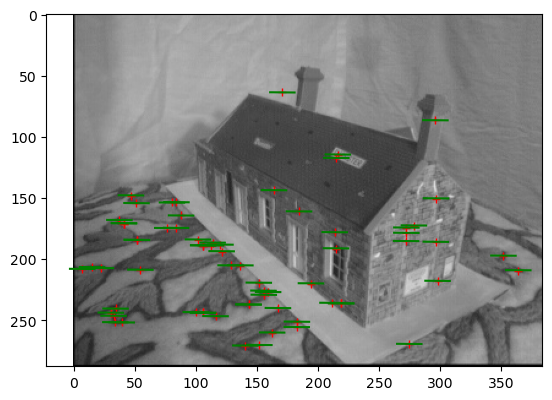

In [42]:
house_1 = Image.open('mp5_part1_data/house1.jpg')
house_2 = Image.open('mp5_part1_data/house2.jpg')

house_F, house_matches = fit_fundamental_matrix_without_groundtruth(np.array(house_1), np.array(house_2))
visualize_fundamental(house_matches, house_F, house_1, house_2)

Number of inliers: 71
Total error: 4.008111298052913


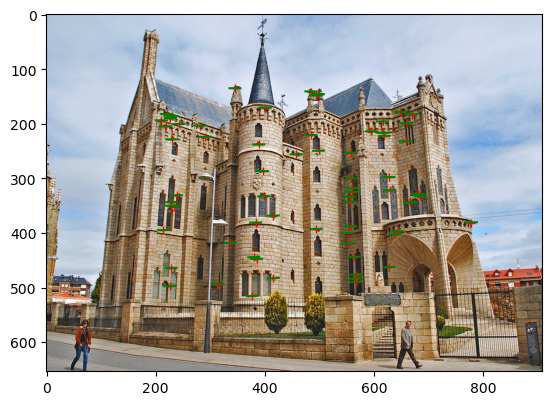

In [41]:
gaudi_1 = Image.open('mp5_part1_data/gaudi1.jpg')
gaudi_2 = Image.open('mp5_part1_data/gaudi2.jpg')

gaudi_F, gaudi_matches = fit_fundamental_matrix_without_groundtruth(np.array(gaudi_1), np.array(gaudi_2))
visualize_fundamental(gaudi_matches, gaudi_F, gaudi_1, gaudi_2)